# Hospitalization Prediction for Elderly People


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

from src.eda import *
from src.config import *
from src.data_extract import *
from src import feature_selection as fs
from src.evaluation import *


# 1. Data Extraction


* *The Mexican Health and Aging Study* (**MHAS**) is a dataset of household surveys designed to collect information on the health, economic status, and quality of life of older adults.
The survey was conducted over 5 time periods, technically known as **Waves**. 
In addition, there are three study subjects: the respondent (r), the spouse (s), and the household (H). For this study, only the first two were used.



## 1.1. Load data

* The data is available on the official **MHAS** site. They are extracted and processed by a **Dataframe**.

In [2]:
mhas = get_data_frame()

Current directory: /home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects
ZIP extracted



## 1.2. Extract data.

* To prepare the data for exploratory analysis (**EDA**) and modeling, common characteristics for the two study subjects are considered and merged into a single data set. 

In [3]:
df = extract(mhas)

/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

# 2. EDA.
* **Data structure**: The data set is divided into 15 sections. Each section quantifies different aspects related to health and socio-economic aspects..

## 2.1. Identification of the target variable
* The target variable belongs to *Section C: Health Care Utilization and Insurance* and is labeled **Medical Care Utilization: Hospital** *`(r/s)#hosp1y`*, where *"r"* refers to "respondent" and *"s"* to "spouse".  Finally, *"#"* goes from 1 to 5 and refers to waves. 

* *rwhosp1y* indicates whether the respondent reports at least one overnight hospital stay in the last 12 months. RwHOSP1Y is coded as 0 if the respondent had no overnight hospital stays, and is coded as 1 if the respondent had at least one overnight hospital stay. 

* *swhosp1y* is taken from the spouse value in wave "w" for *rwhosp1y*. In addition to the special default codes used in *rwhosp1y*, if the respondent is not considered matched in the current cycle and is assumed to be single, a special default value of .u is used. In addition, if the respondent is not considered matched in the current cycle but reports being married, a special default value of .u is used. Similarly, if the respondent is not considered matched in the current cycle but reports being married, a special omitted value of .v is used.

In [4]:
# renaming the dataframe for convenience
target = "pahosp1y"

# plottiing the unique values of the target to spot imbalance}
# with plt.style.context('bmh'):
#         plt.figure(figsize=(10, 6))
#         ax = sns.countplot(x=target, data=df, linewidth=0)
#         ax.set_xlabel("Target")
#         ax.set_ylabel("Count")
#         ax.set_title("Target Distribution")
#         plt.show()

## 2.2. Missing values.

Number of features: 442


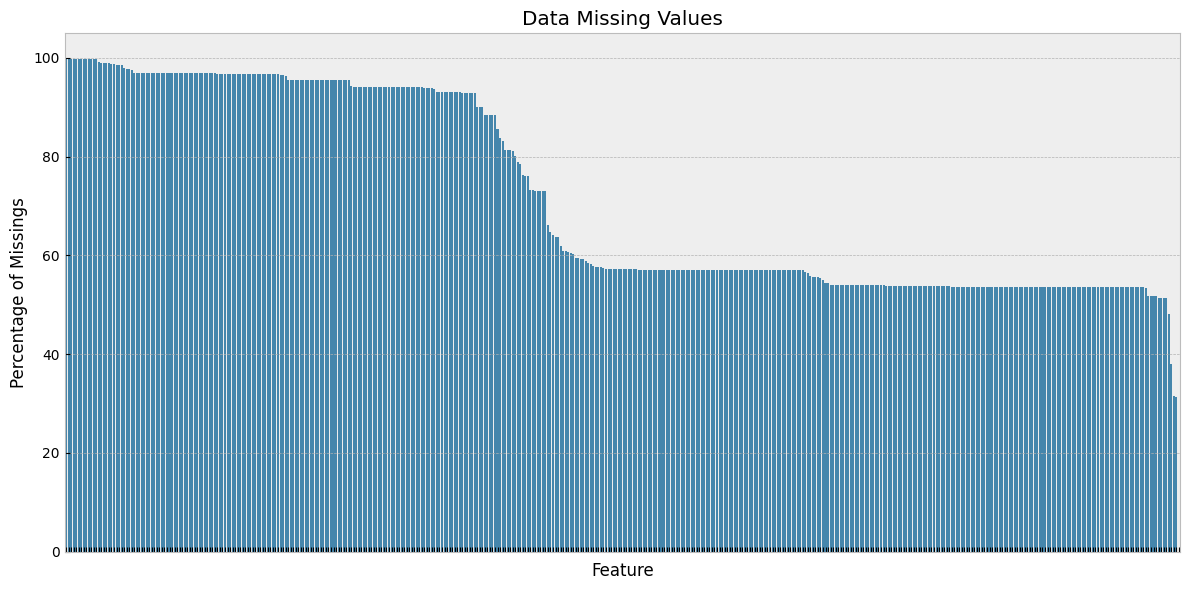

In [6]:
print(f"Number of features: {df.shape[1]}")
plot_missing_values(df)

## 2.3. Data type and unique values.
* Data consists primarily of binary, discrete, and, to a lesser extent, continuous data.

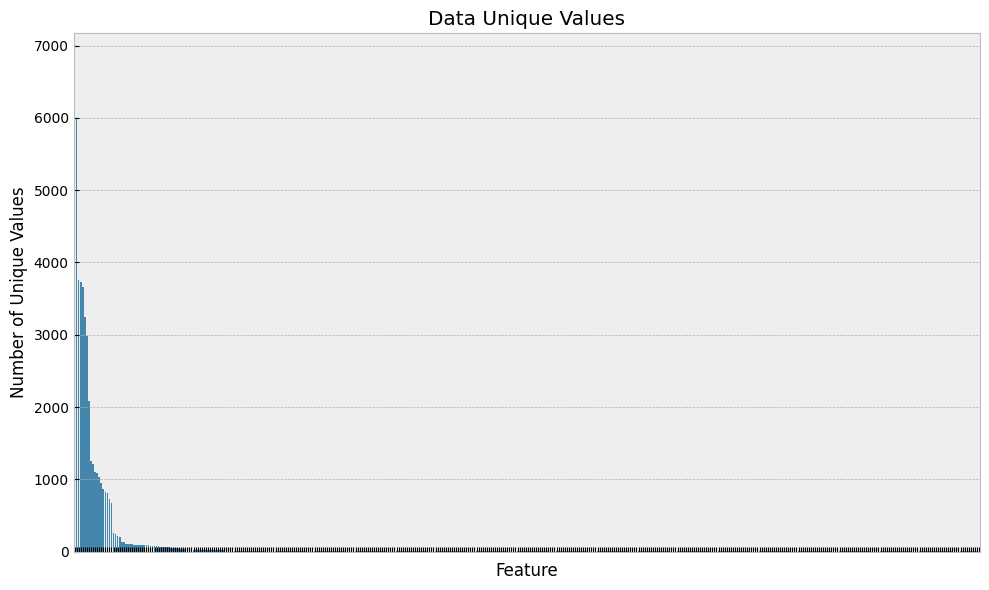

In [7]:
plot_uniques(df)

## 2.4. Correlation between binary features and the target.

* A clear relationship between the characteristics and the target variables is observed by Cramer's V. This statistic is a measure of effect size for the chi-squared test of independence. It measures how two categorical fields are related.

Effect Size (ES) / Interpretation

ES ≤ 0.2 The result is weak. Although the result is statistically significant, the fields are only weakly associated.

0.2 < ES ≤ 0.6 The result is moderate. The fields are moderately related.

**ES > 0.6 The result is strong. The fields are strongly associated.**

/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/eda.py:208: RuntimeWarning: invalid value encountered in scalar divide
  V = np.sqrt(phi_c / min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1))
/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/eda.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Correlation", y="Column", data=corr_df, palette="viridis")


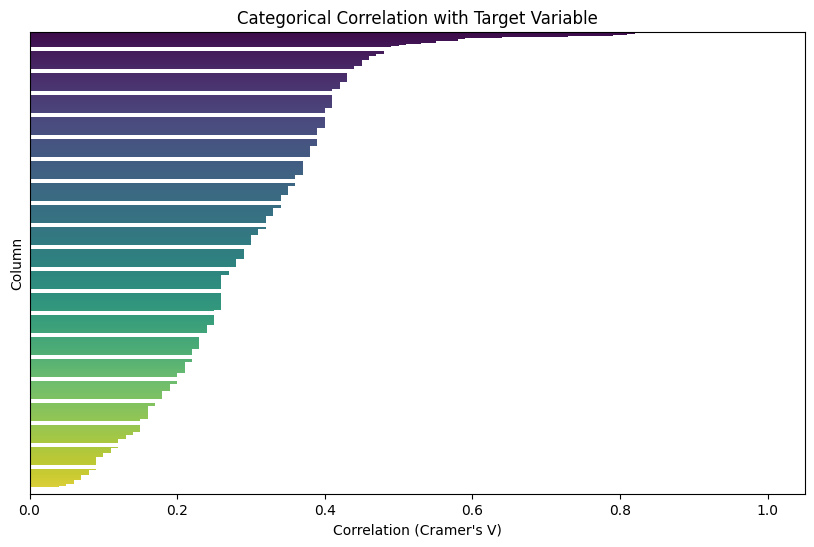

In [8]:
plot_categorical_correlation(df, target)

# 3. Model


## 3.1. Feature Seleccion and Preprocessing

In [5]:
# filtering the data by elderly people only.
df = df.loc[df['paagey']>=50]

# The selected features, we believe are relevant to the model.
selected=['pahosp1y','pahip50e', 'padadage', 'pamomage', 
          'pahibpe', 'parespe', 'pacholst', 'pagrossaa', 
          'paosleep', 'pafallinj', 'pacancre', 'paswell', 
          'parafaany', 'pawheeze', 'paagey', 
          'paarthre', 'padiabe', 'parjudg', 'paweight', 
          'paclims', 'pastroke', 'pasmokev', 
          'pahearaid', 'pameds', 'paheight', 'paglasses', 
          'paeat', 'papaina', 'pagender', 'padrinkb']

print(f"There are {len(selected)} features selected")

df3 = df.where(df['cpindex'] <=  109).dropna(subset=['cpindex'])

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

nulls_percentage = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (nulls_percentage <= 0.5)]

# splitting the data into X and y
y_df = df_s[target]
X_df = df_s.drop(target,axis=1)

There are 30 features selected


In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, shuffle=True)

#PREPROCESADO
X_train = X_train.fillna(X_train.mode().iloc[0]) # Imputer using mode

# Scaling the train data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Normalizing the train data
transformer = PowerTransformer(method='yeo-johnson')
X_train = transformer.fit_transform(X_train)

## Now we apply the same fot test dataset

X_test = X_test.fillna(X_test.mode().iloc[0])

# Scaling the test data
X_test = scaler.transform(X_test)

# Normalizing the test data
X_test = transformer.transform(X_test)

## 3.2. Logistic Regression Model

In [8]:
from sklearn.linear_model import LogisticRegression
import time

log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(X_train, y_train)

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(X_train)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(X_test)[:, 1]

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_test, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.7365
Validation ROC AUC Score: 0.7395


## 3.3. Random Forest Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
import time

# Initialize RandomForest classifier with n_jobs=-1 to use all CPU cores
rf = RandomForestClassifier(n_jobs=-1)

# Measure start time
start_time = time.time()

# Train the model
rf.fit(X_train, y_train)

# Measure completion time
end_time = time.time()

# Calculate elapsed time
training_time = end_time - start_time

# Print training time
print(f"Training time: {training_time} seconds")

# The trained model is in the variable 'rf'

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(X_train)[:, 1]

# Validation data predictions (class 1)
rf_pred_test = rf.predict_proba(X_test)[:, 1]


# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_test = roc_auc_score(y_true=y_test, y_score=rf_pred_test)
print(f"Validation ROC AUC Score: {roc_auc_test:.4f}")

Training time: 2.4604218006134033 seconds
Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9398


## 3.4. XGB Classifier Model

In [11]:
# creating variables that captures the proportion of classes in the target.
zeros=y.value_counts()[0]
ones=y.value_counts()[1]

# This are the parameters that we found to be the best for the model.
params={
        'max_depth': 8, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.07568753700048324, 
        'min_child_weight': 5, 
        'n_estimators': 561, 
        'scale_pos_weight': (zeros/ones)-2.5,
        'n_jobs':-1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
}

# instantiating the model
model = XGBClassifier(**params)

In [12]:
kf = KFold(n_splits=7)

y_test_all = []
y_pred_all = []
y_pred_prob_all = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=3) 
    
    y_test_all.extend(y_test)
    y_pred_all.extend(model.predict(X_test))
    y_pred_prob_all.extend(model.predict_proba(X_test))

[0]	validation_0-logloss:0.56062	validation_1-logloss:0.55869


/opt/.pyenv/versions/3.10.13/envs/ne1ai-project/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.54962	validation_1-logloss:0.54736
[2]	validation_0-logloss:0.53959	validation_1-logloss:0.53727
[3]	validation_0-logloss:0.53008	validation_1-logloss:0.52699
[4]	validation_0-logloss:0.52169	validation_1-logloss:0.51828
[5]	validation_0-logloss:0.51401	validation_1-logloss:0.51070
[6]	validation_0-logloss:0.50697	validation_1-logloss:0.50387
[7]	validation_0-logloss:0.50051	validation_1-logloss:0.49731
[8]	validation_0-logloss:0.49509	validation_1-logloss:0.49193
[9]	validation_0-logloss:0.48899	validation_1-logloss:0.48601
[10]	validation_0-logloss:0.48402	validation_1-logloss:0.48167
[11]	validation_0-logloss:0.47949	validation_1-logloss:0.47760
[12]	validation_0-logloss:0.47574	validation_1-logloss:0.47405
[13]	validation_0-logloss:0.47155	validation_1-logloss:0.47027
[14]	validation_0-logloss:0.46760	validation_1-logloss:0.46611
[15]	validation_0-logloss:0.46395	validation_1-logloss:0.46297
[16]	validation_0-logloss:0.46034	validation_1-logloss:0.45999
[

In [24]:
# Convertir las listas en arrays numpy
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test_all, y_pred_prob_all)

# Calcular el classification_report
report = classification_report(y_test_all, y_pred_all)

print(f'AUC: {auc}')
print(f'F1: {f1_score(y_test_all, y_pred_all)}')
print(report)

AUC: 0.9355943431146284
F1: 0.780461403152696
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61314
         1.0       0.77      0.79      0.78      7305

    accuracy                           0.95     68619
   macro avg       0.87      0.88      0.88     68619
weighted avg       0.95      0.95      0.95     68619



# 4. Evaluation

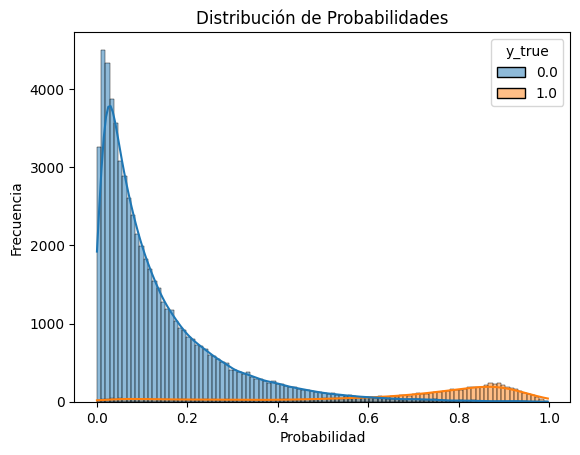

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame con las etiquetas de prueba y las probabilidades predichas
data = pd.DataFrame({'y_true': y_test_all, 'y_pred_prob': y_pred_prob_all})

# Graficar la distribución de probabilidades
sns.histplot(data=data, x='y_pred_prob', hue='y_true', kde=True)

# Agregar etiquetas y título al gráfico
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades')

# Mostrar el gráfico
plt.show()

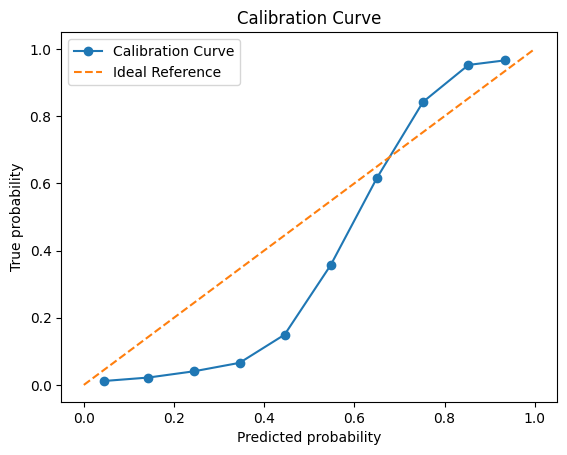

In [26]:
from sklearn.calibration import calibration_curve
# Calcular la curva de calibración
prob_true, prob_pred = calibration_curve(y_test_all, y_pred_prob_all, n_bins=10)

# Graficar la curva de calibración
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration Curve')

# Graficar la línea de referencia ideal
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal Reference')

# Configurar los ejes y la leyenda
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()

# Mostrar el gráfico
plt.show()